

# Imbalanced Learning
The goal of this case study is to use various imbalanced learning models to detect whether a transaction is a normal payment or a fraud.


## Content

* [1. Problem Definition](#0)
* [2. Load Packages and Dataset](#1)
    * [2.1. Load Packages](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
    * [3.2. Feature Importance](#2.3)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)    
* [5.Evaluate Algorithms and Models](#4) 
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Weighted cost sensitive learning](#4.2)   
    * [5.3. Imbalanced xgboost](#4.3) 


<a id='0'></a>
# 1. Problem Definition

In the classification framework defined for this case study, the response variable takes
a value of 1 in case the given transaction is fraud and 0 otherwise.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.The task is to get forecast the fraud. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.The features are the result of PCA transformation and aren't intuitive as far as their names are concerned.

The data can be downloaded from: https://www.kaggle.com/mlg-ulb/creditcardfraud


## 1.1. Imbalanced data

- When we're facing a class imbalance accuracy can be misleading when the imbalance is quite high (e.g. >75-80%)
- Gathering additional data for the minority class is a potentially viable solution
    - This technique may be expensive or impractical


- Several approaches can be applied:
    - Adjusting our metrics (e.g. recall, F-Score )
        - F Score variants:
            - F1 -> Cost of False Negative = False Positive
            - F2 -> Cost of False Negative > False Positive
            - F0.5 -> Cost of False Negative < False Positive
    - Balancing the data (e.g. oversampling, undersampling)
    - Changing the model
    - Changing the optimization (e.g. focal imbalance)

<a id='1'></a>
# 2. Load packages & data

<a id='1.1'></a>
## 2.1. Load packages

In [1]:
# #If required install libraries
# !pip install watermark=="2.3.1"
# !pip install shap=="0.41.0"
# !pip install xgboost=="1.6.2"
# !pip install catboost=="1.0.6"

In [2]:
# !pip install imbalance-xgboost

In [4]:
# Load libraries
import numpy as np
import pandas as pd
import sys
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import imxgboost
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Feature selection
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Metrics
from sklearn import metrics

# Interpretation
#import pandas_profiling as pp
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
sns.set_theme(style="darkgrid")

In [5]:
# magics
%matplotlib inline
%load_ext autoreload
%load_ext watermark
%autoreload 2
%watermark --iversions

sklearn   : 0.23.2
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
numpy     : 1.19.5
shap      : 0.41.0
pandas    : 1.3.5
lightgbm  : 3.3.2
matplotlib: 3.5.2
seaborn   : 0.11.2
xgboost   : 1.6.2
catboost  : 1.0.6



In [6]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

We load the data in this step.

#### <font color='red'>Note : actual data (144MB) available from https://www.kaggle.com/mlg-ulb/creditcardfraud. You should load the full data in case you want to (instead of sample). </font> 

In [7]:
# load dataset
dataset = read_csv('creditcard_sample.csv')

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [8]:
# shape
dataset.shape

(99999, 31)

In [9]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As shown in the results above, the entire data type is float, except Class which is integer, and the variable names aren't intuitive.

In [11]:
# describe data
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,42432.982130,-0.262096,-0.032374,0.676251,0.162603,-0.278507,0.094066,-0.108712,0.056009,-0.046529,...,-0.030852,-0.109079,-0.037027,0.008982,0.132193,0.026657,0.000606,0.001730,97.962094,0.002230
std,17044.825093,1.859057,1.656854,1.322888,1.349249,1.356376,1.301356,1.210925,1.207528,1.121255,...,0.718882,0.634301,0.632911,0.595255,0.441065,0.494541,0.393700,0.325159,264.624210,0.047171
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-31.764946,-73.216718,-9.283925,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,33471.500000,-1.028101,-0.598711,0.176781,-0.711442,-0.898645,-0.647870,-0.600209,-0.137457,-0.698812,...,-0.224509,-0.531305,-0.176416,-0.323712,-0.131794,-0.325102,-0.062534,-0.005355,7.570000,0.000000
50%,44299.000000,-0.260556,0.078315,0.753991,0.192567,-0.314370,-0.157022,-0.069107,0.074130,-0.119105,...,-0.057669,-0.083855,-0.049239,0.064999,0.170104,-0.070347,0.009832,0.023318,26.310000,0.000000
75%,55851.000000,1.153327,0.735736,1.376333,1.032416,0.249733,0.486356,0.414667,0.360506,0.558226,...,0.119190,0.308337,0.081522,0.406281,0.419906,0.300683,0.083025,0.076568,89.000000,0.000000
max,67374.000000,1.960497,18.902453,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,22.614889,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


Let us check the number of fraud vs. non-fraud cases in the data set.

In [12]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(dataset.Class.value_counts().rename(index = class_names))

Not Fraud    99776
Fraud          223
Name: Class, dtype: int64


The dataset is unbalanced with most of the transactions being non-fraud.

<a id='2.2'></a>
## 3.2. Data Visualization

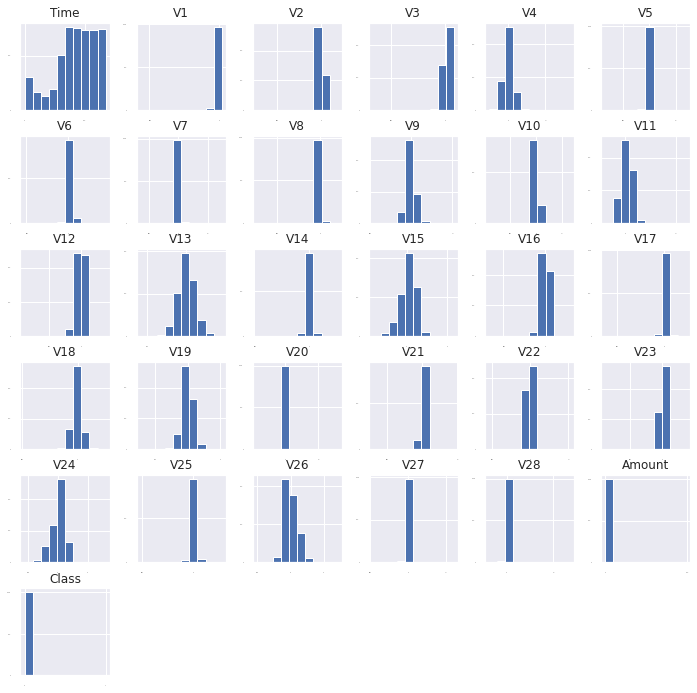

In [13]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

<a id='2.3'></a>
## 3.3. Feature Importance

In [20]:
# find best 10 features
bestfeatures = SelectKBest( k=10)
bestfeatures
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

   Specs         Score
17   V17  20657.815089
14   V14  16227.609484
3     V3  10383.968697
12   V12   9644.179908
10   V10   7909.706201
16   V16   6829.652688
7     V7   6157.563975
11   V11   3567.597482
4     V4   2840.799746
18   V18   2632.036670


Distribution of most of the variables are highly skewed. However, given the variable names aren't known, we don't get much intuition from the plot.

In [14]:
def plot_feature(df, feature, outcome='target'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
  df.hist(feature, ax=ax1)
  ax1.set_xlabel(feature)
  ax1.set_title(f'Histogram for {feature}')
  df.boxplot(feature, by=outcome, ax=ax2)
  ax2.set_ylabel(feature)
  ax2.set_title(f'{feature} grouped by Target')
  plt.show();

#### Plot distribution of top 3 features

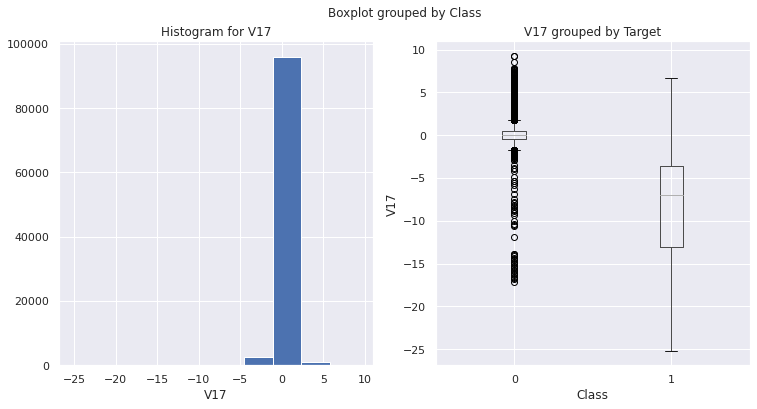

In [17]:
plot_feature(dataset, 'V17', outcome='Class')

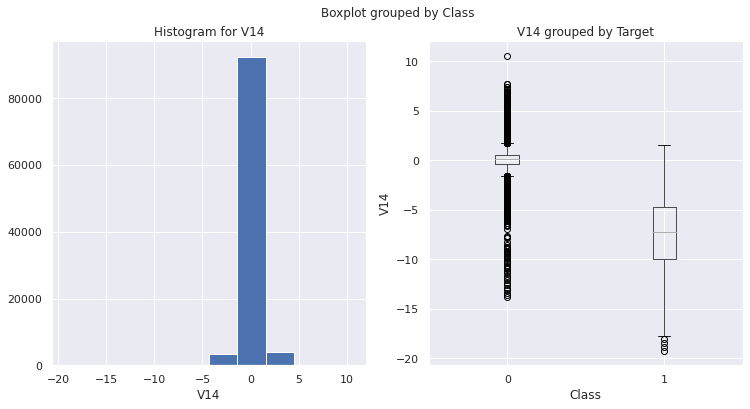

In [18]:
plot_feature(dataset, 'V14', outcome='Class')

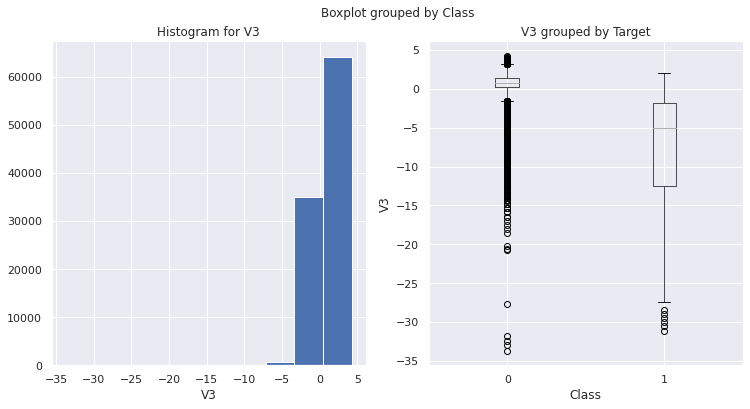

In [19]:
plot_feature(dataset, 'V3', outcome='Class')

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning

In [13]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


There is no null in the data, and the data is already in the float format, so there is no need to clean or categorise the data

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

use f1 as it weights false-negative false-positives equally

In [15]:
# split out validation dataset for the end
Y= dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'recall' # 'f1_macro'

<a id='4.2'></a>
## 5.2 Weighted cost sensitive learning

Applies cost sensitive learning as part of the algorithm.

Instead of changing the distribution of data (ie. down or upsampling) we can adjust the cost of making mistakes.
By adjusting the minority class in a cost-sensitive manner, we obtain a comparable reweighting.

Directly set weights of minority class
- There is a limit here.
    - We put the weights on minority observations in the training dataset.
    - That may not always generalize to the test dataset.

In [16]:
ratio = (len(Y_validation) - sum(Y_validation)) // sum(Y_validation)
print(f'ratio : {ratio}')

ratio : 369


In [17]:
# weights for RandomForestClassifier
weights = {0:1,
           1:10 * ratio}

In [18]:
# test options for classification
num_folds = 5
seed = 7

In [19]:
# spot check some basic Classification algorithms
#Given Data is huge, some of the slower classification algorithms are commented
models = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))
# # Neural Network
# models.append(('NN', MLPClassifier()))
# #Ensemble Models 
# Boosting methods
# models.append(('AB', AdaBoostClassifier()))
# models.append(('GBM', GradientBoostingClassifier())) # n.b. slow
# models.append(('lightgbm', LGBMClassifier()))
models.append(('xgb', XGBClassifier()))
models.append(('weightedxgb', XGBClassifier(scale_pos_weight=ratio)))
# models.append(('catboost', CatBoostClassifier(verbose=False)))
# # Bagging methods
models.append(('RF', RandomForestClassifier())) # n.b. slow
models.append(('weightedRF', RandomForestClassifier(class_weight=weights))) # n.b. slow
# models.append(('ET', ExtraTreesClassifier()))

In [20]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f mean (%f std)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

xgb: 0.828164 mean (0.024057 std)
weightedxgb: 0.834046 mean (0.025741 std)
RF: 0.834581 mean (0.028889 std)
weightedRF: 0.757398 mean (0.021813 std)


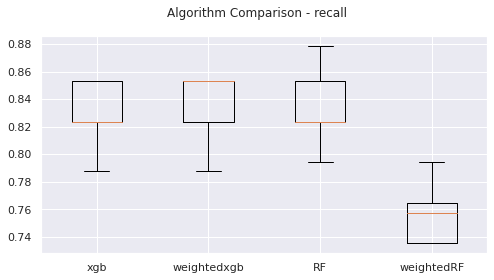

In [21]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - recall')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

Weighting increases recall for xgb, but decreases recall when weighting applied to rf.

### 5.1.1 Check models

#### xgb

In [22]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, Y_train)
xgb_predictions = xgb_model.predict(X_validation)

In [23]:
xgb_df = pd.DataFrame(classification_report(Y_validation, xgb_predictions, output_dict=True)).T
xgb_df

,precision,recall,f1-score,support
0,0.999549,1.000000,0.999774,19946.00000
1,1.000000,0.833333,0.909091,54.00000
accuracy,0.999550,0.999550,0.999550,0.99955
macro avg,0.999774,0.916667,0.954433,20000.00000
weighted avg,0.999550,0.999550,0.999530,20000.00000


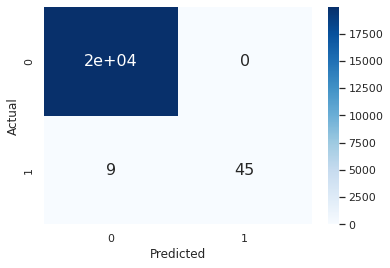

In [24]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, xgb_predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

#### weighted xgb

In [25]:
wxgb_model = XGBClassifier(scale_pos_weight=ratio)
wxgb_model.fit(X_train, Y_train)
wxgb_predictions = wxgb_model.predict(X_validation)

In [26]:
wxgb_df = pd.DataFrame(classification_report(Y_validation, wxgb_predictions, output_dict=True)).T
wxgb_df

,precision,recall,f1-score,support
0,0.999599,0.999900,0.999749,19946.0000
1,0.958333,0.851852,0.901961,54.0000
accuracy,0.999500,0.999500,0.999500,0.9995
macro avg,0.978966,0.925876,0.950855,20000.0000
weighted avg,0.999488,0.999500,0.999485,20000.0000


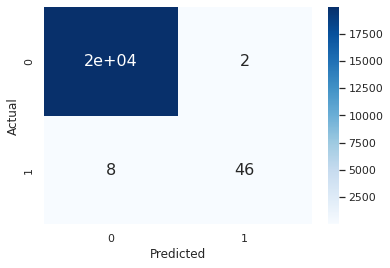

In [27]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, wxgb_predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

<a id='4.3'></a>
## 5.3. Imbalanced xgboost

See: https://medium.com/visionwizard/understanding-focal-loss-a-quick-read-b914422913e7<br>
also: https://pypi.org/project/imbalance-xgboost/

In [28]:
X_train_matrix = X_train.to_numpy()
Y_train_matrix = Y_train.to_numpy()
X_validation_matrix = X_validation.to_numpy()
Y_validation_matrix = Y_validation.to_numpy()

In [29]:
xgboster_focal = imb_xgb(special_objective='focal')
cv_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[1.0,1.5,2.0,2.5,3.0]})
cv_focal_booster

GridSearchCV(estimator=imbalance_xgboost(special_objective='focal'),
             param_grid={'focal_gamma': [1.0, 1.5, 2.0, 2.5, 3.0]})

In [30]:
cv_focal_booster.fit(X_train_matrix, Y_train_matrix)
best = cv_focal_booster.best_estimator_
print(f'Best Gamma {cv_focal_booster}')

Best Gamma GridSearchCV(estimator=imbalance_xgboost(special_objective='focal'),
             param_grid={'focal_gamma': [1.0, 1.5, 2.0, 2.5, 3.0]})


In [31]:
imxgb_predictions = best.predict_determine(X_validation_matrix, y=None)

In [32]:
imxgb_df = pd.DataFrame(classification_report(Y_validation_matrix, imxgb_predictions, output_dict=True)).T
imxgb_df

,precision,recall,f1-score,support
0,0.999599,0.999799,0.999699,19946.0000
1,0.920000,0.851852,0.884615,54.0000
accuracy,0.999400,0.999400,0.999400,0.9994
macro avg,0.959799,0.925826,0.942157,20000.0000
weighted avg,0.999384,0.999400,0.999388,20000.0000


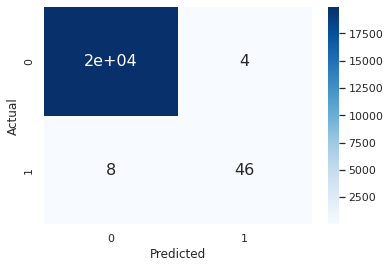

In [33]:
imxgbdf_cm = pd.DataFrame(confusion_matrix(Y_validation_matrix, imxgb_predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
imxgbdf_cm.index.name = 'Actual'
imxgbdf_cm.columns.name = 'Predicted'
sns.heatmap(imxgbdf_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

__Conclusion__:

Weighted xgboost performed the best.